Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
Ответим на вопросы:
- Какой набор предложений можно считать лучшим? 
- Какие метрики стоит проанализировать для принятия правильного решения и как?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats

### Посмотрим на данные

In [2]:
AB_mobil_games = pd.read_csv('~/Проект_1_Задание_2.csv', sep = ';')

In [3]:
AB_mobil_games.shape

(404770, 3)

In [4]:
AB_mobil_games.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [5]:
AB_mobil_games.user_id.nunique()

404770

- id пользователей похожи на id в первом задании, уникальных пользоваетелй меньше, но это и логично, тесты проводят не на всех
- количество уникальных пользователей равно количеству строк в датафрейме, а значит по каждому пользователю есть только одна ячейка данных о сумме покупок, то есть, к примеру, метрика - среднее число покупок будет не показательна 

#### Разберёмся, какая из групп тестовая, а какая контрольная:

In [6]:
# посчитаем количество пользователей
AB_mobil_games.groupby('testgroup', as_index=False).agg({'user_id':'count'})

,testgroup,user_id
0,a,202103
1,b,202667


In [7]:
#посчитаем платящих пользователей в каждой из групп
AB_mobil_games.query('testgroup == "a"').query('revenue > 0')['user_id'].count()

1928

In [8]:
#посчитаем платящих пользователей в каждой из групп
AB_mobil_games.query('testgroup == "b"').query('revenue > 0')['user_id'].count()

1805

In [9]:
#посчитаем ARPU в каждой из групп
AB_mobil_games.query('testgroup == "a"')['revenue'].sum() / AB_mobil_games.query('testgroup == "a"')['revenue'].count()

25.413719736965806

In [10]:
#посчитаем ARPU в каждой из групп
AB_mobil_games.query('testgroup == "b"')['revenue'].sum() / AB_mobil_games.query('testgroup == "b"')['revenue'].count()

26.75128659327863

In [11]:
#вычислим 5% у большей группы и вычтем их из её размера
26.75128659327863 - (26.75128659327863 / 100 * 5)

25.413722263614698

- в группе a 1928 платящих пользователей, как в контрольной, в группе b - 1805, как в тестовой, согласно заданию
- в группе a всего 202103 пользователя, как в контрольной, в группе b - 202667, как в тестовой, согласно заданию
- в группе b ARPU составляет 26.7512, что на 5% (с округлением до 4 знака) выше, чем в группе a (25.4137) 
- получается, что a - это контрольная группа, а b - тестовая.

#### переименуем названия групп осмысленно:

In [12]:
AB_mobil_games['testgroup'] = AB_mobil_games['testgroup'].replace({'a':'control', 'b' : 'test'})

In [13]:
AB_mobil_games.query('testgroup == "control"').query('revenue > 0')

,user_id,revenue,testgroup
72,73,351,control
341,342,290,control
385,386,250,control
416,417,37324,control
712,713,255,control
...,...,...,...
404304,404305,360,control
404315,404316,262,control
404543,404544,369,control
404602,404603,251,control


Первичные выводы:
- среднее число покупок, как говорилось выше, всегда будет 1
- нет данных о времени покупок, поэтому отпадет возможность посчитать скорость второй и последущей покупок, пожизненную ценность, удержание, DAU, MAU и пр.
- количество товаров в заказе не рассчитать 
- возможно данные для каждого пользователя уже суммированы по нескольким покупкам, а может это и одна покупка

Можем посчитать:
- 1 ARPU (что-то о нём мы знаем из условий, кроме того, он у нас равен среднему чеку). Навскидку, метрика для нас нежелательная.
- 2 ARPPU - большинство пользователей в обеих группах не платят, это мешает оценить коммерческий эффект. Как раз доход с платящего пользователя будет более чувствителен.
- 3 CR - конверсия пользователя в покупателя, другими словами, доля платящих пользователей из всех. Новые акционные предложения прямым образом должны влиять на CR в покупку.

    - дополнительно посмотрим общую выручку

### Метрика 1 ARPU

средний доход с пользователя

#### Визуализируем данные по покупкам. Контрольная группа:

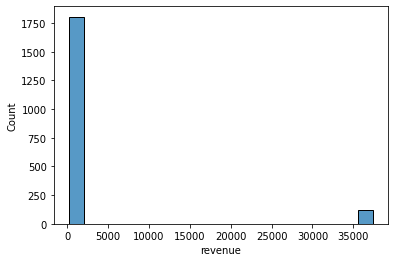

In [30]:
sns.histplot(AB_mobil_games.query('testgroup == "control"').query('revenue > 0')['revenue'], bins=20)
#сразу избавимся от нулевых значений, их слишком много, но так как это ARPU, то мы их должны учесть в дальнейшем

#### есть выбросы аж за 35000:

In [31]:
#смотрим максимальные значения
AB_mobil_games.query('testgroup == "control"').query('revenue > 0').sort_values(by = 'revenue').tail(20)

,user_id,revenue,testgroup
88358,88359,37341,control
321550,321551,37342,control
321014,321015,37344,control
173850,173851,37345,control
360696,360697,37347,control
343212,343213,37349,control
183253,183254,37351,control
356812,356813,37353,control
144685,144686,37355,control
215440,215441,37357,control


- есть много дорогих покупок, но их несоизмеримо меньше, чем недорогих, судя по графику. Надо посмотреть описание данных, чтобы понять распределение покупок.

In [32]:
AB_mobil_games.query('testgroup == "control"').query('revenue > 0').sort_values(by = 'revenue')['revenue'].describe()
#дорогих покупок меньше 25%. Ищем дальше

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [33]:
AB_mobil_games.query('testgroup == "control"').query('revenue > 0')['revenue'].quantile(q=0.94)
#примерил подхоящий квантиль для выброса

37295.0

- только около 6% покупок являются сверхдорогими, оставльные намного меньше и близки по величине между собой.

#### распеделение у нас будет явно ненормальным, но проверим для порядка:

In [34]:
stats.shapiro(AB_mobil_games.query('testgroup == "control"')['revenue'])
#совершенно не нормальное

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)

#### Визуализируем данные по покупкам. Тестовая группа:

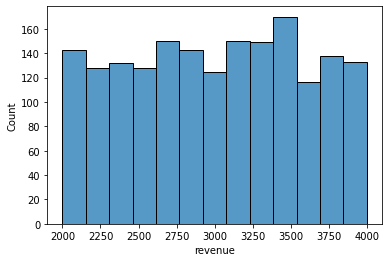

In [35]:
sns.histplot(AB_mobil_games.query('testgroup == "test"').query('revenue > 0'), x='revenue')
#сразу избавимся от нулевых значений, их слишком много, но так как это ARPU, то мы их должны учесть в дальнейшем

- распределение с меньшими перепадами, почти ровное, на нормальное тоже не похоже, а с учётом необходимого нам для ARPU наличия нулевых покупок, точно не нормальное
- в отличие от контрольно группы здесь более стабильные покупки

#### также проверим на тесте Шапиро-Уилка:

In [36]:
stats.shapiro(AB_mobil_games.query('testgroup == "test"')['revenue'])
#совершенно не нормальное

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)

#### ещё раз посмотрим на ARPU у пользователей тестовой и контрольной групп (они же в нашем случе и AOV тоже):

In [39]:
AB_mobil_games.query('testgroup == "test"')['revenue'].mean()

26.75128659327863

In [38]:
AB_mobil_games.query('testgroup == "control"')['revenue'].mean()

25.413719736965806

- очень небольшие значения и они очень близки между собой, хотя мы помним, что реальные покупки - это числа другого порядка и разница в характере покупок у групп есть значительная

#### Формирование гипотез
- H0 - акционный наборы у тестовой и контрольной группы одинаково влияют на средний доход с пользователя 
- H1 - акционные наборы дают различный эффект, в тестовой группе он немого лучше

### Проведение AB-теста
#### Чеки пользователей - количественные данные, распределены не нормально, с учётом значительных перепадов значений t-тест применять тут не следует, группы независимые и их две, при этом они примерно равны применяем критерий Манна-Уитни

In [40]:
stats.mannwhitneyu(AB_mobil_games.query('testgroup == "test"')['revenue'], \
                   AB_mobil_games.query('testgroup == "control"')['revenue'])

MannwhitneyuResult(statistic=20468349325.0, pvalue=0.06269701316074398)

- (!) ARPU для пользователей в группах статистически значимо не отличаются (порог p-value для статистики учитываем как 0,05)
<br><br>
- в целом эту метрику учитывать не стоит: у нас слишком много неплатящих пользователей, то есть пользователей совсем отдельной категории, которую лучше вообще отсечь при анализе предложений (лучше подумать, как их перевести в категорию хоть сколько-то платящих и как увеличенить доход с них), кроме того метрика даже примерно не отражает реальных данных о сумме некоторой покупки (если мы конечно имеем единичную покупку, а не сумму многих покупок)
- однако, при рассчёте обнаружились важные сведения о данных


### Метрика 2 ARPPU

средний доход с платящего пользователя

Здесь как раз мы будем использовать данные о покупках кроме нулевых, поэтому визуализации из предыдущей части подойдут и сюда. Также мы можем их совместить.

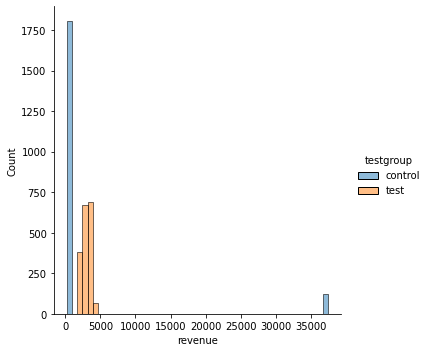

In [49]:
sns.displot(data=AB_mobil_games.query('revenue > 0'), x="revenue", hue="testgroup", bins=50)

#### сначала проверим распределения на нормальность:

In [50]:
stats.shapiro(AB_mobil_games.query('testgroup == "control"').query('revenue > 0')['revenue'])
#у контрольной группы распределение не нормальное

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

In [51]:
stats.shapiro(AB_mobil_games.query('testgroup == "test"').query('revenue > 0')['revenue'])
#у тестовой распределение также не нормальное

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

#### посмотрим на ARPPU у пользователей тестовой и контрольной групп:

In [52]:
AB_mobil_games.query('testgroup == "control"').query('revenue > 0')['revenue'].mean()

2663.9984439834025

In [53]:
AB_mobil_games.query('testgroup == "test"').query('revenue > 0')['revenue'].mean()

3003.6581717451522

- отличие заметное
- доля различия в этой метрике выше, чем доля различия в размере групп

#### Формирование гипотез
- H0 - акционный наборы у тестовой и контрольной группы одинаково влияют на средний доход с платящего пользователя 
- H1 - акционные наборы дают различный эффект, в тестовой группе он немого лучше

### Проведение AB-теста (1)
#### Чеки пользователей - количественные данные, распределены не нормально, перепады значений в контрольной группе значительны, группы сильно не похожи по распределениям, группы независимые и их две, при этом они примерно равны. Как и в предыдущий раз применяем критерий Манна-Уитни

In [55]:
stats.mannwhitneyu(AB_mobil_games.query('testgroup == "control"').query('revenue != 0')['revenue'], \
                   AB_mobil_games.query('testgroup == "test"').query('revenue != 0')['revenue'])

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

- (!) ARPPU (в нашем случае ранжированный доход) для пользователей в группах статистически значимо отличаются
<br><br>
- есть все основания отклонить нулевую гипотезу и сказать, что акционные предложения в тестовой группе влияют на средний доход с платящего пользования по-другому, нежели акционные предложения в контрольной группе
- вероятность взять из тестовой группы более высокое по рангу значение оплаты, чем из контрольной группы - выше

### Проведение AB-теста (2)
#### Попробуем поработать с методом bootstrap и посмотреть уже действительно на ARPPU, посчитав средние значения в выборках. Как мы помним, некоторая разница в средних есть и она в пользу тестовой группы.

In [56]:
#создаём пустой список для разницы средних
mean_diff = []

#создаём цикл со случайным взятием из нужного числа выборок
for i in range(10000):
#делаем настройку, что возьмется изначальное количество рядов и что они будут браться с повторением в контрольной группе
    sample_data_control = AB_mobil_games.query('testgroup == "control"').query('revenue > 0').sample(frac=1, replace=True)
    #из получившегося датафрейма будем брать каждый раз среднее
    sample_mean_control = sample_data_control.revenue.mean()
    
    #то же самое повторим для тестовой группы
    sample_data_test = AB_mobil_games.query('testgroup == "test"').query('revenue > 0').sample(frac=1, replace=True)
    sample_mean_test = sample_data_test.revenue.mean()
    
    #соберём каждый раз разницу в средних
    sample_mean_diff = sample_mean_test - sample_mean_control
    mean_diff.append(sample_mean_diff)

In [57]:
pd.Series(mean_diff).quantile([0.025, 0.975])
#разница в средних включает в себя 0

0.025    -66.130908
0.975    734.597528
dtype: float64

#### визуализируем, построив доверительный интервал значений распределения средних

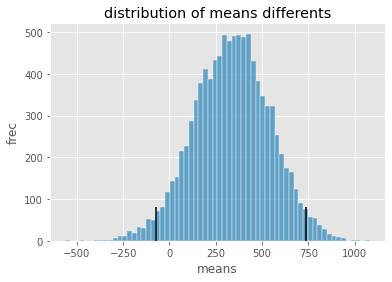

In [98]:
#делаем из списка датафрейм
mean_diff_data = pd.DataFrame(mean_diff)
#определяем 95-процентный доверительный интервал
conf_int = mean_diff_data.quantile([0.025, 0.975])

#строим график с отсечками интервала
sns.histplot(mean_diff, kde=False)

plt.vlines(conf_int,ymin=0,ymax=80,linestyle='-')
plt.xlabel('means')
plt.ylabel('frec')
plt.title("distribution of means differents")

plt.show()

- (!) ARPPU для пользователей в группах статистически значимо не отличаются - нулевое значение (совпадение средних) находится внутри доверительного интервала.
<br><br>
- нулевую гипотезу не отклоняем - акционный наборы у тестовой и контрольной группы одинаково влияют на средний доход с платящего пользователя.

### Проведение AB-теста (3)
#### С такими перепедами в значениях, конечно хорошо бы посчитать разницу в медианах, не усреднять значения

In [58]:
#поглядим на медианы наших распределений
AB_mobil_games.query('testgroup == "control"').query('revenue > 0').revenue.median(), \
AB_mobil_games.query('testgroup == "test"').query('revenue > 0').revenue.median()
#значительная разница

(311.0, 3022.0)

In [59]:
#создаём пустой список для разницы медиан
median_diff = []

#создаём цикл со случайным взятием из нужного числа
for i in range(10000):
#делаем настройку, что возьмется изначальное количество рядов и что они будут браться с повторением по контрольной группе
    sample_data_control = AB_mobil_games.query('testgroup == "control"').query('revenue > 0').sample(frac=1, replace=True)
    #из получившегося датафрейма будем брать каждый раз медиану
    sample_median_control = sample_data_control.revenue.median()
    
    #то же самое повторим для тестовой группы
    sample_data_test = AB_mobil_games.query('testgroup == "test"').query('revenue > 0').sample(frac=1, replace=True)
    sample_median_test = sample_data_test.revenue.median()
    
    #соберём каждый раз разницу в медианах
    sample_median_diff = sample_median_test - sample_median_control
    median_diff.append(sample_median_diff)

In [60]:
pd.Series(median_diff).quantile([0.025, 0.975])
#нулевого значения нет и близко

0.025    2658.5
0.975    2760.0
dtype: float64

#### визуализируем, построив доверительный интервал значений распределения средних

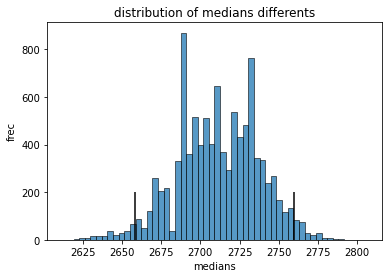

In [61]:
#строим график с доверительным интервалом, как и выше, но теперь - для определения разниц в медианах
median_diff_data = pd.DataFrame(median_diff)
conf_int = median_diff_data.quantile([0.025, 0.975])

sns.histplot(median_diff, kde=False)

plt.vlines(conf_int,ymin=0,ymax=200,linestyle='-')
plt.xlabel('medians')
plt.ylabel('frec')
plt.title("distribution of medians differents")

plt.show()

- (!) Медианы доходов с платящих пользователей в группах статистически значимо отличаются - нулевого значения (совпадения) нет и близко.
<br><br>
- есть все основания отклонить нулевую гипотезу и сказать, что акционные предложения в тестовой группе влияют на доход с платящего пользования по-другому, нежели акционные предложения в контрольной группе

- медиана доходов с платящих пользователей в тестовой группе выше, чем в контрольной

### Дополнительно: Пока мы около bootstrap, рассчитаем разницу по 75-му процентилю
Небольшие процентили будут очевидно в пользу тестовой группы. Также мы значем, что 6% в контрольной группе - это суперпокупки и они явно будут выше, чем в тестовой. Что лежит в 75 и других процентилях?

In [70]:
#делаем по аналогии с примерами выше
diff = []

for i in range(10000):
    sample_data_control = AB_mobil_games.query('testgroup == "control"').query('revenue > 0').sample(frac=1, replace=True)
    sample_control = sample_data_control.revenue.quantile(q=0.95)#(q=0.85)
    
    #то же самое повторим для тестовой группы
    sample_data_test = AB_mobil_games.query('testgroup == "test"').query('revenue > 0').sample(frac=1, replace=True)
    sample_test = sample_data_test.revenue.quantile(q=0.95)#(q=0.85)
    
    #соберём каждый раз разницу в медианах
    sample_diff = sample_test - sample_control
    diff.append(sample_diff)

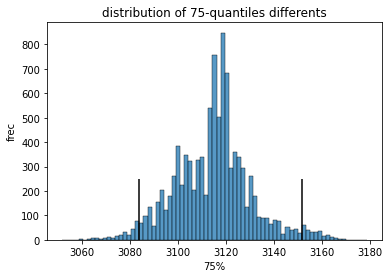

In [69]:
#строим график с доверительным интервалом для определения разниц - 75-процентиль
diff_data = pd.DataFrame(diff)
conf_int = diff_data.quantile([0.025, 0.975])

sns.histplot(diff, kde=False)

plt.vlines(conf_int,ymin=0,ymax=250,linestyle='-')
plt.xlabel('75%')
plt.ylabel('frec')
plt.title("distribution of 75-quantiles differents")

plt.show()

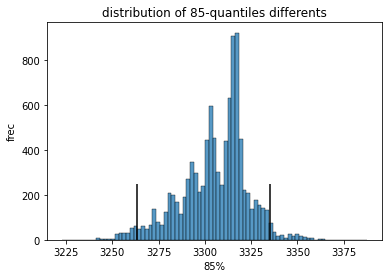

In [67]:
#строим график с доверительным интервалом для определения разниц - 85-процентиль
diff_data = pd.DataFrame(diff)
conf_int = diff_data.quantile([0.025, 0.975])

sns.histplot(diff, kde=False)

plt.vlines(conf_int,ymin=0,ymax=250,linestyle='-')
plt.xlabel('85%')
plt.ylabel('frec')
plt.title("distribution of 85-quantiles differents")

plt.show()

### Метрика 3 CR

конверсия в покупку, или доля платящих пользователей среди всех пользователей

#### Визуализируем эти доли в двух группах, предварительно подготовив датасет:

In [73]:
#создаём новую колонку с булевыми значениями оплаты (нулевая - True, ненулевая - False)
AB_mobil_games['is_zero'] = AB_mobil_games['revenue'] == 0

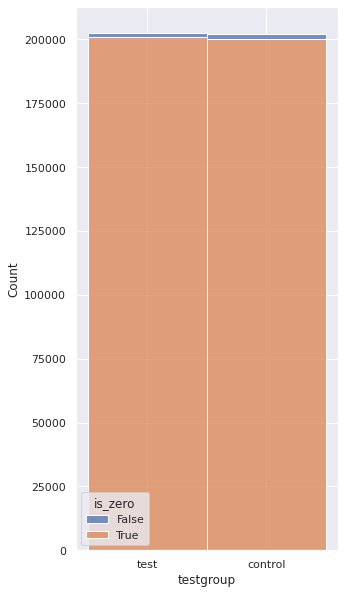

In [74]:
sns.set(rc={'figure.figsize':(4.7,10)})
ax = sns.histplot(AB_mobil_games, x='testgroup', hue = 'is_zero', multiple='stack')

- как и указывалось в условии, в контрольной группе платящих пользователей немного больше, а сама группа немного меньше. Это видно и на графике

#### Посчитаем конверсию в покупку у обеих групп:

In [75]:
AB_mobil_games.query('testgroup == "control"').query('is_zero == False')['is_zero'].count() / \
AB_mobil_games.query('testgroup == "control"').query('is_zero == True')['is_zero'].count()

0.009631572374172599

In [76]:
AB_mobil_games.query('testgroup == "test"').query('is_zero == False')['is_zero'].count() / \
AB_mobil_games.query('testgroup == "test"').query('is_zero == True')['is_zero'].count()

0.00898626917983491

- и так тоже мы видим, что CR у контрольной группы выше

#### Формирование гипотез
- H0 - акционный наборы у тестовой и контрольной группы одинаково влияют желание пользователей заплатить за товар в приложении
- H1 - акционные наборы мотивируют чаще покупать и меняют конверсию пользователя в покупку

### Проведение AB-теста
#### Переменные качественные (да\нет), независимые и их всего две, поэтому проводим тест с помощью Хи-квадрата Пирсона:

In [77]:
from scipy.stats import chi2_contingency

In [78]:
stat, p1, dof, chi = chi2_contingency(pd.crosstab(AB_mobil_games.testgroup, AB_mobil_games.is_zero))
stat, p1 

(4.374729521260405, 0.03647561892312613)

- (!) покупательский интерес для пользователей в группах статистически значимо отличается
<br><br>
- есть все основания отклонить нулевую гипотезу и сказать, что акционные предложения меняют конверсию в покупку
- в контрольной группе CR статистически значимо выше

### Дополнительно: Посчитаем общую выручку в каждой группе 

In [79]:
AB_mobil_games.query('testgroup == "control"')['revenue'].sum()

5136189

In [38]:
AB_mobil_games.query('testgroup == "test"')['revenue'].sum()

5421603

In [39]:
(5421603 - 5136189) / 5421603 * 100

5.264383983851271

In [40]:
5136189 * 1.05264383983851271

5406577.711096331

- в тестовой группе выручка больше на 5.3 % (почти как и средний чек на пользователя)

### Выводы

- Результаты исследования неоднозначны, что говорит о слишком разных акционных предложениях со своими плюсами и минусами. 
- Не хватает данных времени, чтобы можно было оценить, в какие сроки совершались разного размера покупки, может быть это дало бы большее понимание для принятия решения.
<br><br>
- На данный момент, если и выкатывать предложения на всех, то рекомендуется склониться к предложениям из тестовой группы. Там стабильные и сравнительно крупные покупки, выше общий доход (основополагающий показатель бизнеса), хоть и всего на 5,3%. Абсолютное значение ARPPU выше (хоть и незначительно), ранжированное значение ARPPU статистически значимо выше, медианное (а также более высокие процентили) значение дохода с платящих пользователей также статистически значимо выше, чем в контрольной группе. Всё это чаще всего значимее для бизнеса, чем конверсия в покупку и небольшой процент весьма нестабильных суперпокупок.
<br><br>
- Да, контрольная группа конвертится лучше (а значит - что-то пользователей здорово мотивирует покупать), но предложения такие, что покупки в подавляющем большинстве мизерные по сравнению с тестовой группой, а ведь число покупок сопоставимое. В контрольной группе большинство интересуются, пробуют, но потратиться хорошенько мотивации у них не хватает. Конечно, есть 6% суперпокупателей - это те, чьё сердечко прямо задело и они готовы хорошо вложиться, либо это крупные клиенты затесались среди обычных (тогда есть вопросы к дизайну исследования). Как бы то ни было, убери\потеряй их и провалишься дальше некуда. В этом ненадёжность ставки на предложения из контрольной группы. Эти предложения надо доработать так, чтобы с ними ощутимо подрос общий доход, или чтобы доля суперпокупок стала такой, чтобы среднее значение на платящего пользователя значительно выше, чем в тестовой группе. И вот тогда (тоже не без риска) можно подумать об их раскатывании.
<br><br>
- А пока есть смысл раскатывать добротные и надёжные как AK-74 предложения из тестовой группы. А ещё лучше подумать, что улучшает конверсию в контрольной группе и добавить это в предложения тестовой.
<br><br>
- (!)Оговорка одна - если стадия бизнес-модели или ориентированность бизнеса в данный момент нацелена именно на конверсию, или в данном периоде был уговор посмотреть на свои мощности и "пробить" порог, к примеру, в 30 тыс. у.е., посмотрев на активность суперклиентов, то тогда, безусловно, катить стоит контрольную. Но этого из условий мы не знаем, аналитику следует обсудить такие вещи с бизнесом обязательно.


##### Задание взято из программы обучения на Аналитика данных  в Karpov Courses